In [150]:
#Importing Requreid librarys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

Reading the Excel file and creating a Dataframe

In [28]:
#Loading dataSet
raw_df = pd.read_excel('/Users/vardhanvarikuti/Programming Files/INT375DSToolbox/Online Retail.xlsx')
df = raw_df.copy()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Attribute Information:\
**InvoiceNo:** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.\
**StockCode:** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.\
**Description:** Product (item) name. Nominal.\
**Quantity:** The quantities of each product (item) per transaction. Numeric.\
**InvoiceDate:** Invice Date and time. Numeric, the day and time when each transaction was generated.\
**UnitPrice:** Unit price. Numeric, Product price per unit in sterling.\
**CustomerID:** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.\
**Country:** Country name. Nominal, the name of the country where each customer resides.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## Data Cleaning

In [30]:
df = df.dropna(subset = ['CustomerID'])   # remove rows without customer ID
df['CustomerID'] = df['CustomerID'].astype(int)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']  # Added a colmun of Amount spent for each purchase
df['IsCanceled'] = df['InvoiceNo'].astype(str).str.startswith('C')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int64         
 7   Country      406829 non-null  object        
 8   TotalPrice   406829 non-null  float64       
 9   IsCanceled   406829 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 31.4+ MB


### Objective 1

In [31]:
# Total spending per customer
customer_spending = df.groupby('CustomerID')['TotalPrice'].sum().reset_index().rename(columns={'TotalPrice': 'TotalSpent'})
customer_spending

,CustomerID,TotalSpent
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40
...,...,...
4367,18280,180.60
4368,18281,80.82
4369,18282,176.60
4370,18283,2094.88


In [8]:
# Number of orders per customer
orders_per_customer = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index().rename(columns={'InvoiceNo': 'TotalOrders'})
orders_per_customer

,CustomerID,TotalOrders
0,12346,2
1,12347,7
2,12348,4
3,12349,1
4,12350,1
...,...,...
4367,18280,1
4368,18281,1
4369,18282,3
4370,18283,16


In [80]:
# basket_size = df.groupby('InvoiceNo')['Quantity'].sum().reset_index().rename(columns={'Quantity': 'BasketSize'})
# basket_size

In [9]:
df_clean = df[~df['InvoiceNo'].astype(str).str.startswith('C')] #Datframe without cancled data
basket_size = df_clean.groupby('InvoiceNo')['Quantity'].sum().reset_index().rename(columns={'Quantity': 'BasketSize'})
basket_size

,InvoiceNo,BasketSize
0,536365,40
1,536366,12
2,536367,83
3,536368,15
4,536369,3
...,...,...
18531,581583,76
18532,581584,120
18533,581585,278
18534,581586,66


In [10]:
canceled_orders = df[df['IsCanceled']].groupby('CustomerID')['InvoiceNo'].nunique().reset_index().rename(columns={'InvoiceNo': 'CanceledOrders'})
canceled_orders

,CustomerID,CanceledOrders
0,12346,1
1,12352,3
2,12359,2
3,12362,3
4,12365,1
...,...,...
1584,18272,1
1585,18274,1
1586,18276,2
1587,18277,1


In [11]:
# Merging 3 dfs into a single DataFrame
from functools import reduce
dfs = [customer_spending, orders_per_customer, canceled_orders]
customer_behavior = reduce(lambda left, right: pd.merge(left, right, on='CustomerID', how='outer'), dfs)

# Fill NaN values in CanceledOrders with 0 (for customers who never canceled)
customer_behavior['CanceledOrders'] = customer_behavior['CanceledOrders'].fillna(0).astype(int)

customer_behavior = customer_behavior.dropna()

# Show top rows of final behavior summary
print(customer_behavior.info())
customer_behavior.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      4372 non-null   int64  
 1   TotalSpent      4372 non-null   float64
 2   TotalOrders     4372 non-null   int64  
 3   CanceledOrders  4372 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 136.8 KB
None


,CustomerID,TotalSpent,TotalOrders,CanceledOrders
0,12346,0.00,2,1
1,12347,4310.00,7,0
2,12348,1797.24,4,0
3,12349,1757.55,1,0
4,12350,334.40,1,0


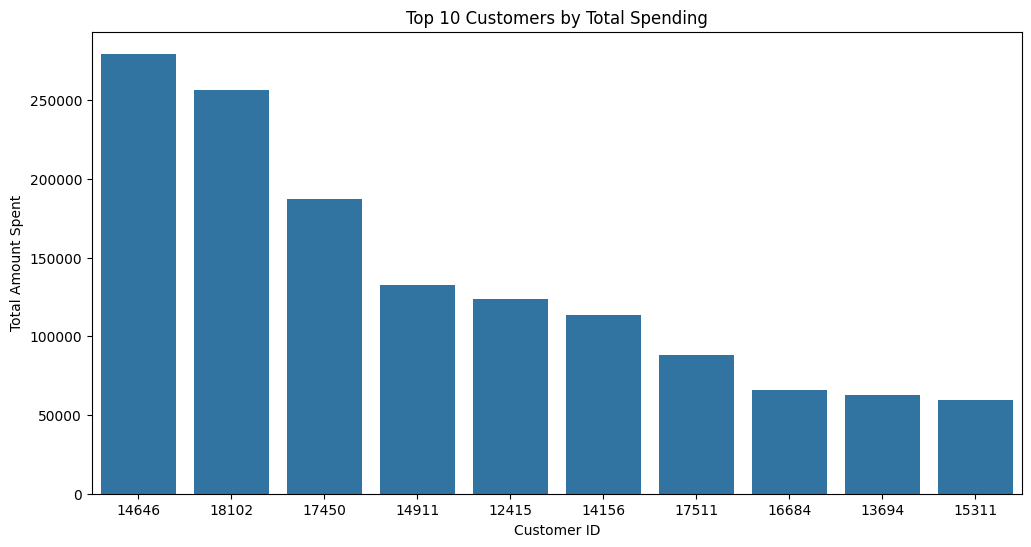

In [49]:
top_spenders = customer_behavior.sort_values('TotalSpent', ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(data=top_spenders, x='CustomerID', y='TotalSpent', order=top_spenders['CustomerID'])
plt.title('Top 10 Customers by Total Spending')
plt.xlabel('Customer ID')
plt.ylabel('Total Amount Spent')
# plt.xticks(rotation=45)
# plt.tight_layout()
plt.show()

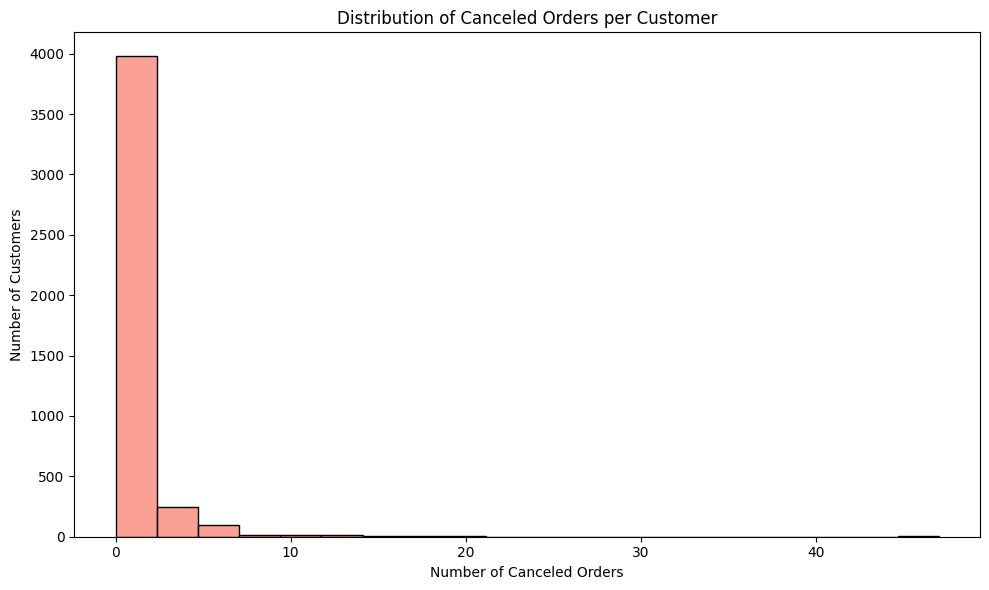

In [14]:
plt.figure(figsize=(10,6))
sns.histplot(customer_behavior['CanceledOrders'], bins=20, kde=False, color='salmon')
plt.title('Distribution of Canceled Orders per Customer')
plt.xlabel('Number of Canceled Orders')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

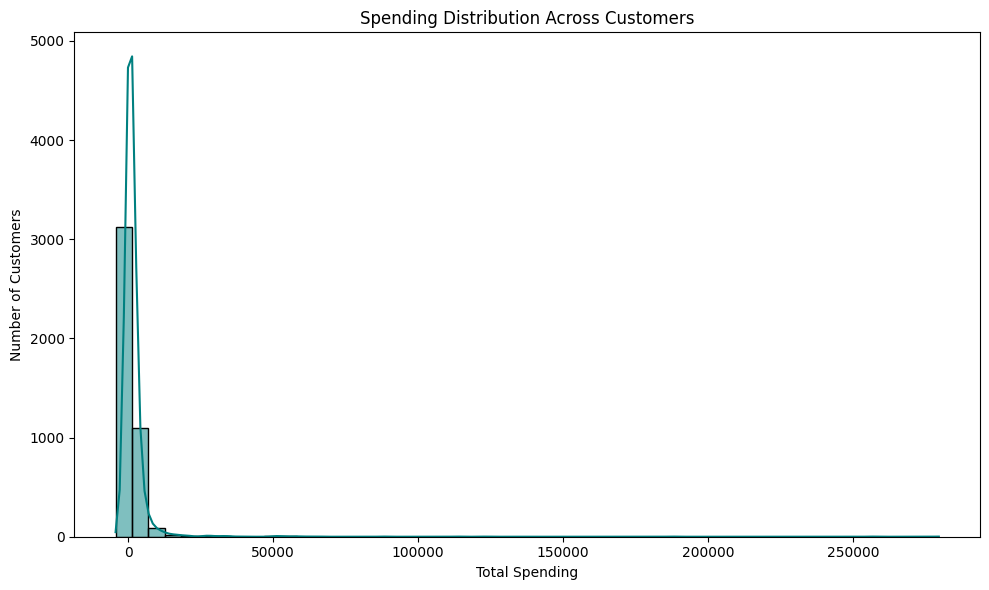

In [15]:
plt.figure(figsize=(10,6))
sns.histplot(customer_behavior['TotalSpent'], bins=50, kde=True, color='teal')
plt.title('Spending Distribution Across Customers')
plt.xlabel('Total Spending')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

/var/folders/bc/ws8p4cy94m73rp_z3y3x4qvh0000gn/T/ipykernel_62740/836818393.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




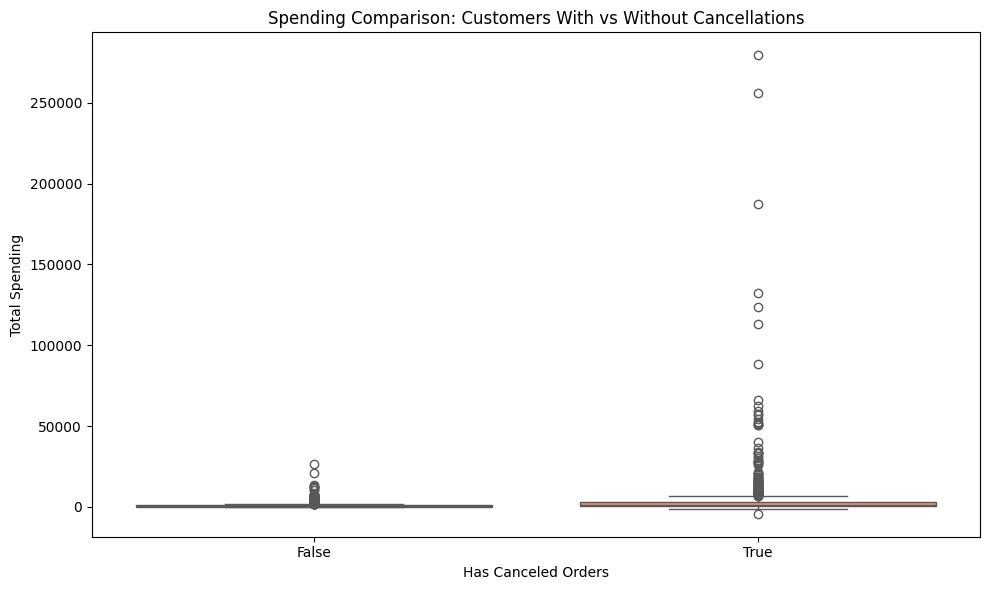

In [51]:
# Add a new column: HasCanceled (True if canceled orders > 0)
customer_behavior['HasCanceled'] = customer_behavior['CanceledOrders'] > 0

plt.figure(figsize=(10,6))
sns.boxplot(data=customer_behavior, x='HasCanceled', y='TotalSpent', palette='Set2')
plt.title('Spending Comparison: Customers With vs Without Cancellations')
plt.xlabel('Has Canceled Orders')
plt.ylabel('Total Spending')
plt.tight_layout()
plt.show()

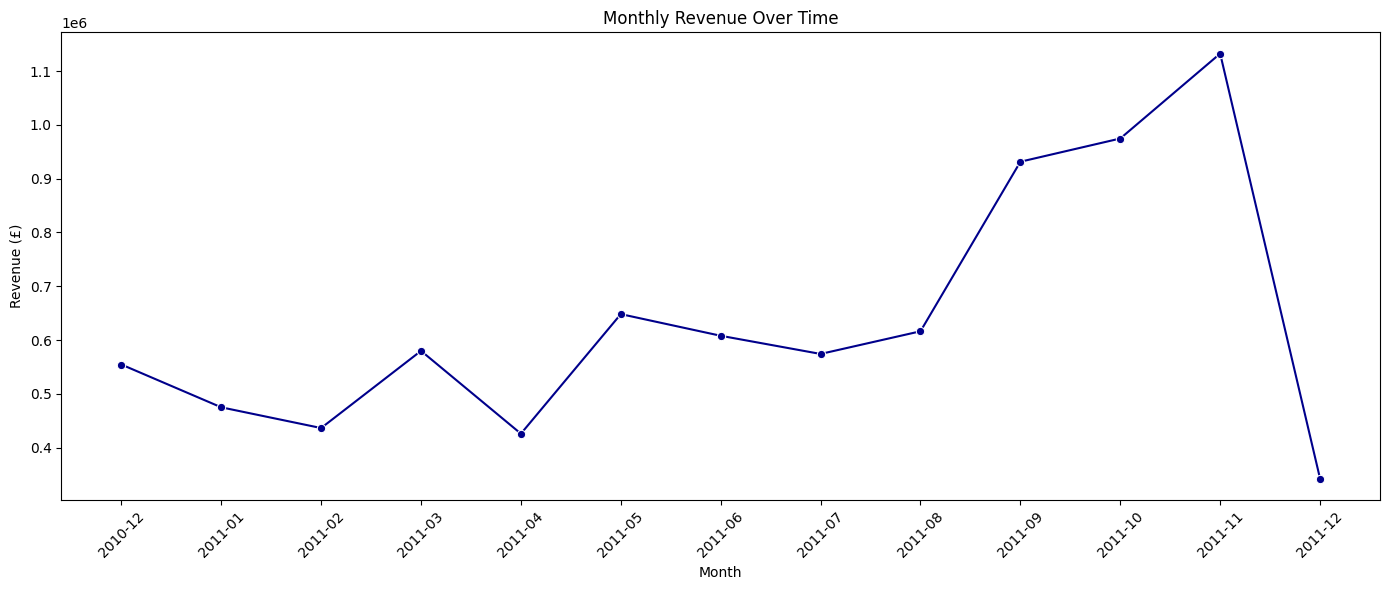

In [18]:
# Extract Year-Month for grouping
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

# Monthly Revenue
monthly_revenue = df.groupby('InvoiceMonth')['TotalPrice'].sum().reset_index()
monthly_revenue['InvoiceMonth'] = monthly_revenue['InvoiceMonth'].astype(str)

plt.figure(figsize=(14,6))
sns.lineplot(data=monthly_revenue, x='InvoiceMonth', y='TotalPrice', marker='o', color='darkblue')
plt.title('Monthly Revenue Over Time')
plt.xlabel('Month')
plt.ylabel('Revenue (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/bc/ws8p4cy94m73rp_z3y3x4qvh0000gn/T/ipykernel_62740/4268125423.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_revenue.values, y=country_revenue.index, palette='crest')


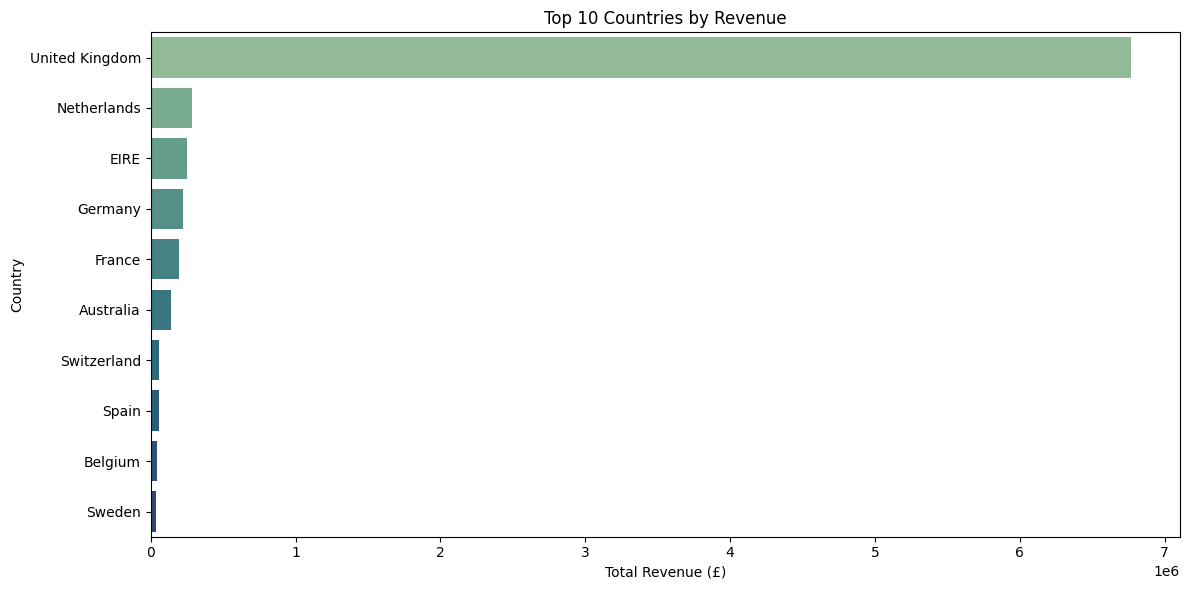

In [19]:
country_revenue = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=country_revenue.values, y=country_revenue.index, palette='crest')
plt.title('Top 10 Countries by Revenue')
plt.xlabel('Total Revenue (£)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

/var/folders/bc/ws8p4cy94m73rp_z3y3x4qvh0000gn/T/ipykernel_62740/1844854175.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_avg_spending['AvgSpendingPerOrder'], y=top_avg_spending.index, palette='flare')


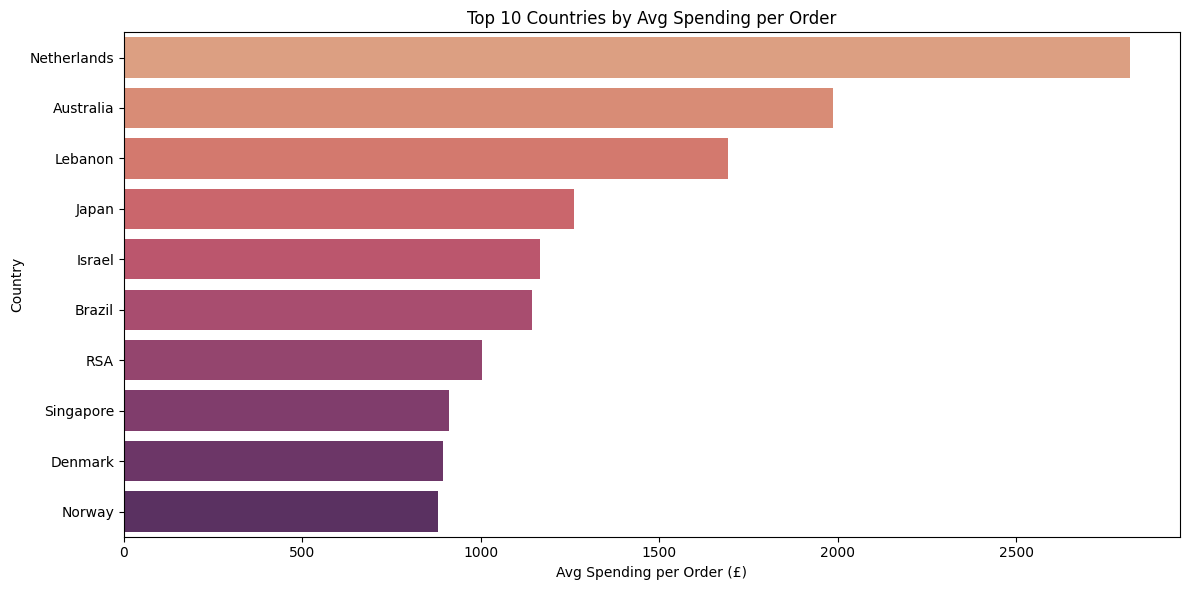

In [20]:
# Total per country / total orders per country
country_avg_spending = df.groupby('Country').agg({'TotalPrice': 'sum', 'InvoiceNo': 'nunique'})
country_avg_spending['AvgSpendingPerOrder'] = country_avg_spending['TotalPrice'] / country_avg_spending['InvoiceNo']
top_avg_spending = country_avg_spending.sort_values('AvgSpendingPerOrder', ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_avg_spending['AvgSpendingPerOrder'], y=top_avg_spending.index, palette='flare')
plt.title('Top 10 Countries by Avg Spending per Order')
plt.xlabel('Avg Spending per Order (£)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

### Objective 2 RFM

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [138]:
df = raw_df.copy()
df = df.dropna(subset=['CustomerID'])
df['TotalPrice'] = df['UnitPrice'] * df['Quantity']
# Create a reference date (1 day after the last transaction)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
# RFM Calculation
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days, # Recency : less is better 
    'InvoiceNo': 'nunique', # Frequency : more is better
    'TotalPrice': 'sum' # Monetary : more is better
    }).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
# RFM Scoring using quantiles
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels = [5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method ='first'), 5, labels = [1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels = [1, 2, 3, 4, 5])
# Combine RFM scores
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis = 1).astype(int)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
0,12346.0,326,2,0.00,1,2,1,121,4
1,12347.0,2,7,4310.00,5,4,5,545,14
2,12348.0,75,4,1797.24,2,3,4,234,9
3,12349.0,19,1,1757.55,4,1,4,414,9
4,12350.0,310,1,334.40,1,1,2,112,4


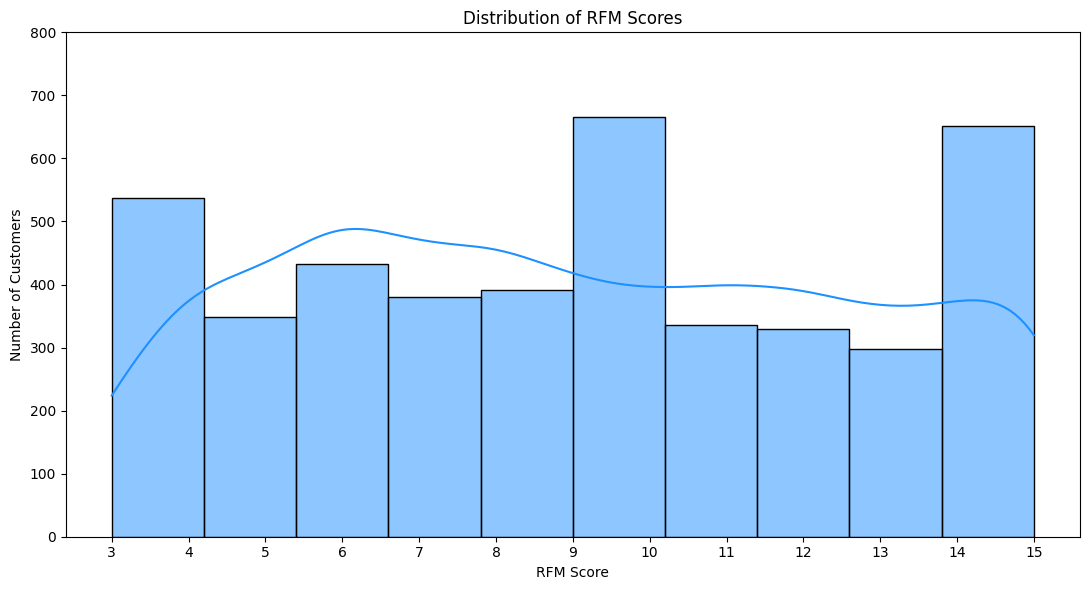

In [111]:
plt.figure(figsize=(11,6))
sns.histplot(rfm['RFM_Score'], bins=10, kde = True, color='dodgerblue')
plt.title('Distribution of RFM Scores')
plt.xlabel('RFM Score')
plt.ylabel('Number of Customers')
plt.xticks(range(rfm['RFM_Score'].min(), rfm['RFM_Score'].max() + 1))
plt.yticks(range(0, 900, 100))
plt.tight_layout()
plt.show()

In [141]:
def segment_customer(row):
    r = int(row['R_Score'])
    f = int(row['F_Score'])
    score = row['RFM_Score']

    if score >= 13:
        return 'Champions'
    elif score >= 10:
        return 'Loyal'
    elif r >= 4 and f >= 3:
        return 'Potential Loyalist'
    elif r >= 3 and f <= 2:
        return 'Need Attention'
    elif r <= 2 and f >= 3:
        return 'At Risk'
    elif r == 1 and f == 1:
        return 'Lost'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

/var/folders/bc/ws8p4cy94m73rp_z3y3x4qvh0000gn/T/ipykernel_62740/1747493194.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




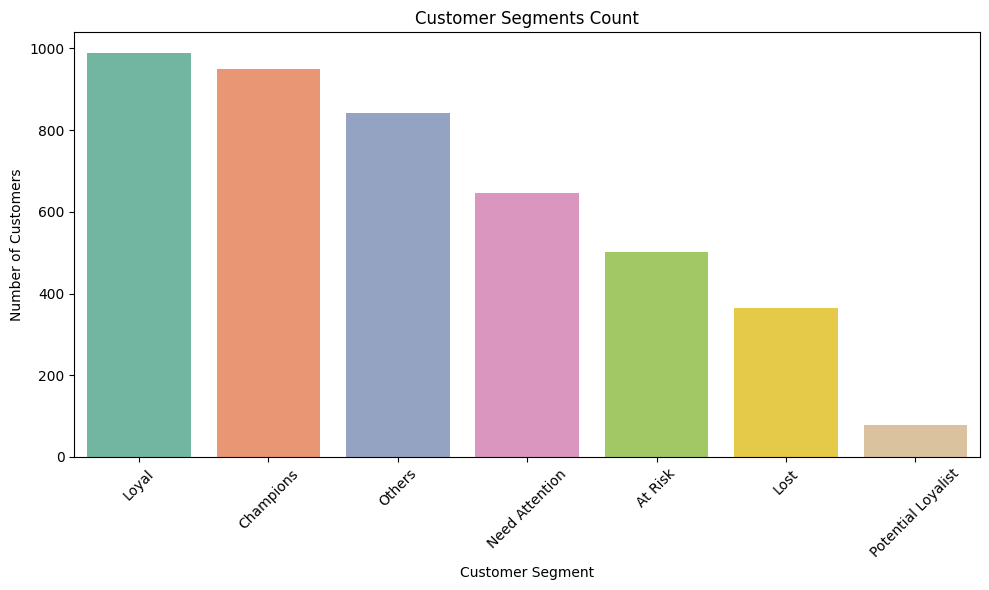

In [149]:
segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

plt.figure(figsize=(10, 6))
sns.barplot(data=segment_counts, x='Segment', y='Count', palette='Set2')
plt.title('Customer Segments Count')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Determing K value for K means clustring